# Hamiltonian NN (HNN) in (q, p) evaluation
by Jae Hoon (Daniel) Lee

- Some of rountines have been borrowed from Y. Chen's train codes.

In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
solver = scipy.integrate.solve_ivp

In [ ]:
import torch.nn as nn
device = 'cpu'

In [ ]:
N = 2
O = np.zeros((N,N))
Id = np.eye(N)
S = np.vstack([np.hstack([O,Id]),np.hstack([-Id,O])])
St = torch.tensor(-S, dtype=torch.float32).to(device)
class MLP(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(MLP,self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,output_size)
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

  def grad(self,x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      hamiltonian = self(x)
      gradient = torch.autograd.grad(hamiltonian.sum(),x,create_graph=True,retain_graph=True)

    return torch.matmul(gradient[0],St)
   

  def fvec(self,t,x):
    return self.grad(x)

In [4]:
input_size = 4
output_size = 1
hidden_size = 200
num_trials = 10
mynet = MLP(input_size,hidden_size,output_size).to('cpu')

In [ ]:
M = 100 * 1
tend = 5.0 * 1
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

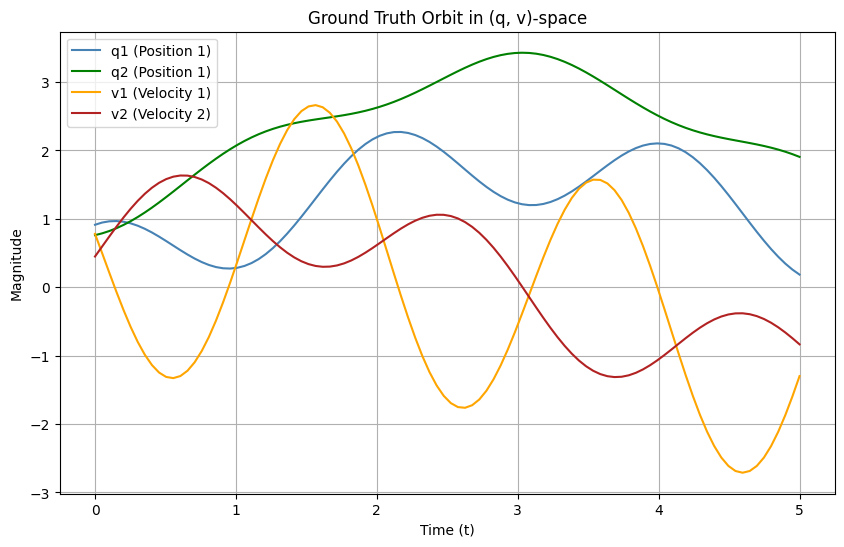

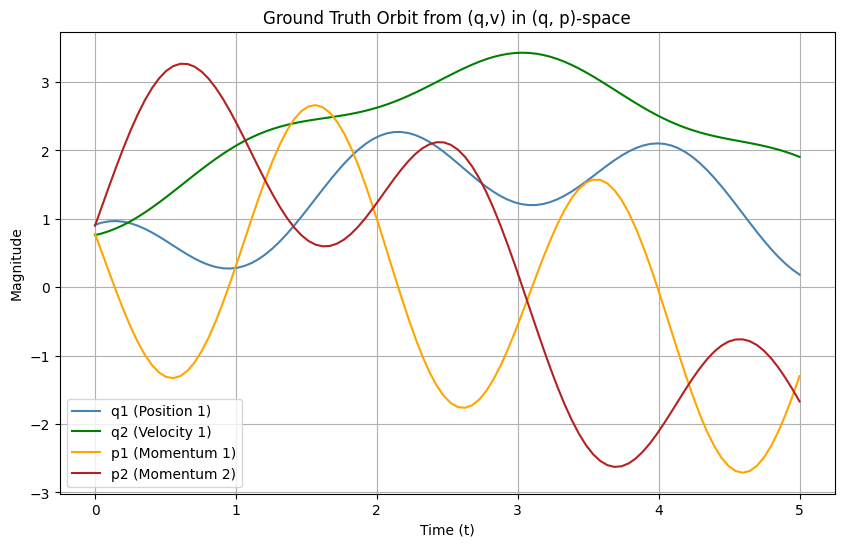

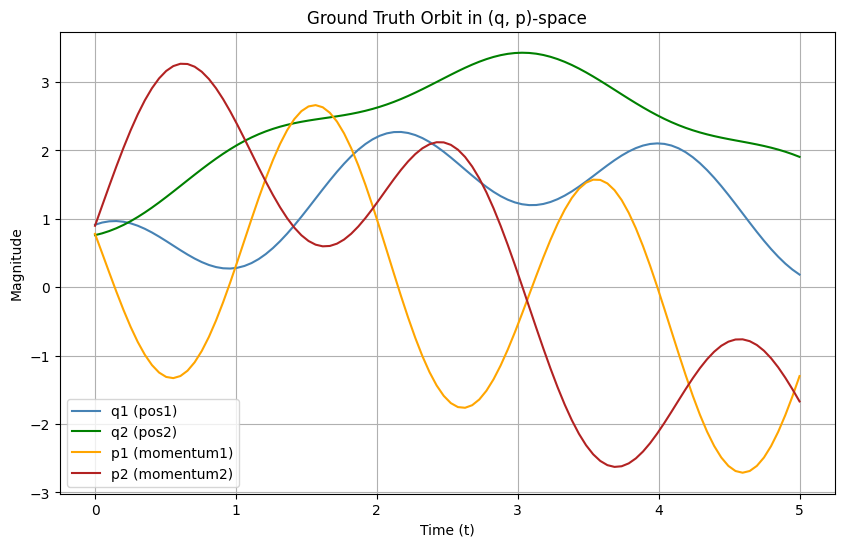

In [ ]:
# Ground truth
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0

# equations of motion
def func(t, state):
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (-k1*(state[0]-l1)+k2*(state[1]-state[0]-l2))/m1
  dvdt[3] = -k2*(state[1]-state[0]-l2)/m2
  return dvdt

state = []
for i in range(1):
  s = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  state.append(s)

sol = solver(func, [0, tend], state[i], t_eval=t_eval) 

sol = solver(func, [0, tend], state[i], t_eval=t_eval)
tval = sol['t']

# ODE in/out v: = (q1, q2, v1, v2) order
q1 = sol['y'][0]
q2 = sol['y'][1]
v1 = sol['y'][2]
v2 = sol['y'][3]
tval = sol['t']

# (q, v) trajectory
true_x_qv = sol['y'].T

plt.figure(figsize=(10, 6))
plt.plot(tval, true_x_qv[:,0], 'steelblue', label='q1 (Position 1)')
plt.plot(tval, true_x_qv[:,1], 'g', label='q2 (Position 1)')
plt.plot(tval, true_x_qv[:,2], 'orange', label='v1 (Velocity 1)')
plt.plot(tval, true_x_qv[:,3], 'firebrick', label='v2 (Velocity 2)')
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.title('Ground Truth Orbit in (q, v)-space')
plt.legend()
plt.grid(True)
plt.show()

# For HNN, (q, v) is converted to (q, p)
p1 = m1 * v1
p2 = m2 * v2

plt.figure(figsize=(10, 6))
plt.plot(tval, q1, 'steelblue', label='q1 (Position 1)')
plt.plot(tval, q2, 'g', label='q2 (Velocity 1)')
plt.plot(tval, p1, 'orange', label='p1 (Momentum 1)')
plt.plot(tval, p2, 'firebrick', label='p2 (Momentum 2)')
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.title('Ground Truth Orbit from (q,v) in (q, p)-space')
plt.legend()
plt.grid(True)
plt.show()


# initial value (q1, q2, p1, p2 order)
state_qp_init = []
for i in range(1):
  # transfomred to (q, p) from (q,v) initial value of Y. Chen's
  s = (0.91369884, 0.76173912, 0.7811432 * m1,  0.44947022 * m2)
  state_qp_init.append(s)

# equations of motion (q, p space)
def func_qp(t, state_qp):
  """
  ODE for the serial mass-spring system (q, v space)
  state = [q1, q2, p1, p2]
  dvdt = [v1, v2, p1[dot], p2[dot]]
  """
  dvdt = np.zeros_like(state_qp)
  
  # dq/dt = v
  dvdt[0] = state_qp[2] / m1 # p1
  dvdt[1] = state_qp[3] / m2 # p2
  
  # dp/dt = f (force computation)
  # f1 = -k1*(q1-l1)+k2*(q2-q1-l2)
  dvdt[2] = -k1*(state_qp[0]-l1)+k2*(state_qp[1]-state_qp[0]-l2)
  # f2 = -k2*(q2-q1-l2)/m2
  dvdt[3] = -k2*(state_qp[1]-state_qp[0]-l2)
  
  return dvdt

# Trajectory computation
for i in range(1):
  sol_qp= solver(func_qp, [0, tend], state_qp_init[i], t_eval=t_eval)
  tval = sol['t']
  
# (q, p) trajectory
true_x_qp = sol_qp['y'].T
  

# plot in (q, p)
plt.figure(figsize=(10, 6))
plt.title('Ground Truth Orbit in (q, p)-space')
plt.plot(tval, true_x_qp[:,0], 'steelblue', label='q1 (pos1)')
plt.plot(tval, true_x_qp[:,1], 'g', label='q2 (pos2)')
plt.plot(tval, true_x_qp[:,2], 'orange', label='p1 (momentum1)')
plt.plot(tval, true_x_qp[:,3], 'firebrick', label='p2 (momentum2)')
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()



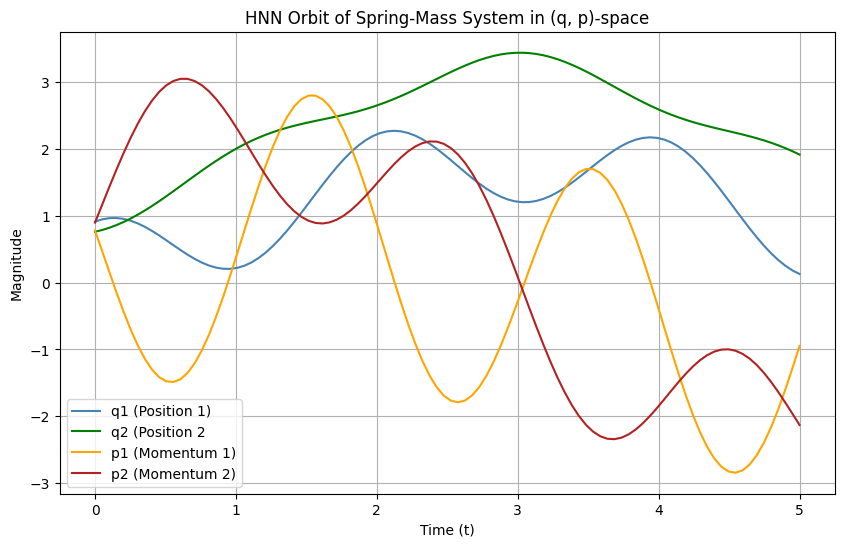

In [ ]:
# simulation
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0

state = []
for i in range(1):
  s = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  state.append(s)

q1_0, q2_0, v1_0, v2_0 = state[0]
p1_0, p2_0 = m1*v1_0, m2*v2_0
x0 = (q1_0, q2_0, p1_0, p2_0) # modified to (q, p) input

trial = 9

mynet.load_state_dict(torch.load("./model/danieljh_hnn_ms_qp_sep_sc_lr_{}".format(trial), map_location="cpu"))
mynet.eval()

import pandas as pd
A = pd.read_csv("./data/hnn_A_ms_qp_sep_sc.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/hnn_B_ms_qp_sep_sc.csv", header=None, dtype=np.float32)

A = np.asmatrix(A)
B = np.asmatrix(B)
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
mynet.eval()
mynet.cpu()
def fvec_np(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  output = mynet.grad(x).squeeze(0)
  output = torch.matmul(A, output)
  output = output.squeeze(0)    
  return output.detach().cpu().numpy()

res = scipy.integrate.odeint(fvec_np,x0,t_eval)

hnn_x_qp = res

plt.figure(figsize=(10, 6))
plt.plot(t_eval,hnn_x_qp[:,0], 'steelblue', label='q1 (Position 1)')
plt.plot(t_eval,hnn_x_qp[:,1], 'g', label='q2 (Position 2')
plt.plot(t_eval,hnn_x_qp[:,2], 'orange', label='p1 (Momentum 1)')
plt.plot(t_eval,hnn_x_qp[:,3], 'firebrick', label='p2 (Momentum 2)')
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.title('HNN Orbit of Spring-Mass System in (q, p)-space')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
def Hamiltonian_qv(orbits_qv):
    """
    Computes the total energy (Hamiltonian) of the system
    based on the given state vector (q1, q2, v1, v2)
    """
    q1 = orbits_qv[:,0]
    q2 = orbits_qv[:,1]
    v1 = orbits_qv[:,2]
    v2 = orbits_qv[:,3]
    
    # Kinetic Energy: K = 0.5 * m * v^2
    kinetic = 0.5 * (m1 * (v1**2) + m2 * (v2**2))
    
    # Potential Energy: V = 0.5 * k * x^2
    potential = 0.5 * (k1 * (q1-l1)**2 + k2 * (q2-q1-l2)**2)

    return (kinetic + potential)

def Hamiltonian_qp(orbits_qp):
    """
    Computes the total energy (Hamiltonian) of the system
    based on the given state vector (q1, q2, v1, v2)
    """
    q1 = orbits_qp[:,0]
    q2 = orbits_qp[:,1]
    p1 = orbits_qp[:,2]
    p2 = orbits_qp[:,3]
    
    # Kinetic Energy: K = 0.5 * m * v^2
    kinetic = 0.5 * ((p1**2) / m1  + (p2**2) / m2)
    
    # Potential Energy: V = 0.5 * k * x^2
    potential = 0.5 * (k1 * (q1-l1)**2 + k2 * (q2-q1-l2)**2)

    return (kinetic + potential)

In [ ]:
def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = mynet.forward(x).squeeze(0)
  return ne.detach().cpu().numpy()

Hmodel_hnn_x_qp = net_energy(hnn_x_qp, t_eval).reshape((M))
Hmodel_true_x_qp = net_energy(true_x_qp, t_eval).reshape((M))

Htrue_hnn_x_qp = Hamiltonian_qp(hnn_x_qp).reshape((M))
Htrue_true_x_qp = Hamiltonian_qp(true_x_qp).reshape((M))

hnn_x_qv = hnn_x_qp.copy()
hnn_x_qv[:,2] = hnn_x_qp[:,2] / m1
hnn_x_qv[:,3] = hnn_x_qp[:,3] / m2

Htrue_hnn_x_qv = Hamiltonian_qv(hnn_x_qv).reshape((M))
Htrue_true_x_qv = Hamiltonian_qv(true_x_qv).reshape((M))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_fig1(true_x_qp, hnn_x_qp, t_eval, Htrue_true_x_qp, Htrue_hnn_x_qp, Hmodel_true_x_qp, Hmodel_hnn_x_qp):
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    tpad = 7

    # --- Top Left Plot (0, 0): Ground Truth Trajectory ---
    axes[0, 0].plot(t_eval, true_x_qp[:, 0], 'steelblue', label='q1 (Position 1)')
    axes[0, 0].plot(t_eval, true_x_qp[:, 1], 'g', label='q2 (Position 2)')
    axes[0, 0].plot(t_eval, true_x_qp[:, 2], 'orange', label='p2 (Momentum 1)')
    axes[0, 0].plot(t_eval, true_x_qp[:, 3], 'firebrick', label='p2 (Momentum 2)')
    axes[0, 0].set_ylabel('Magnitude')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_title('Ground Truth Orbit in (q, p)')
    axes[0, 0].legend(loc='upper right', fontsize=8)
    axes[0, 0].grid(True)

    # --- Top Right Plot (0, 1): Model Prediction Trajectory ---
    axes[0, 1].plot(t_eval, hnn_x_qp[:, 0], 'steelblue', label='q1 (Position 1)')
    axes[0, 1].plot(t_eval, hnn_x_qp[:, 1], 'g', label='q2 (Position 2)')
    axes[0, 1].plot(t_eval, hnn_x_qp[:, 2], 'orange', label='p1 (Momentum 1)')
    axes[0, 1].plot(t_eval, hnn_x_qp[:, 3], 'firebrick', label='p2 (Momentum 2)')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_title('HNN Orbit in (q, p)')
    axes[0, 1].legend(loc='upper right', fontsize=8)
    axes[0, 1].grid(True)

    # --- Bottom Left Plot (1, 0): True Hamiltonian Perspective ---
    axes[1, 0].plot(t_eval, Htrue_true_x_qp, 'k-', label='H_true(True_x_qp)', linewidth=2)
    axes[1, 0].plot(t_eval, Htrue_hnn_x_qp, 'b--', label='H_true(HNN_x_qp)', linewidth=2)
    axes[1, 0].set_title("True Hamiltonian in (q,p)", pad=tpad)
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('True Energy in (q, p)')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(True)

    # --- Bottom Right Plot (1, 1): Learned Hamiltonian Perspective ---
    axes[1, 1].plot(t_eval, Hmodel_true_x_qp, 'k-', label='H_hnn_qp (True_x_qp)', linewidth=2)
    axes[1, 1].plot(t_eval, Hmodel_hnn_x_qp, 'b--', label='H_hnn_qp (HNN_x_qp)', linewidth=2)
    axes[1, 1].set_title("Hamiltonian Learned by HNN (q,p)", pad=tpad)
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('HNN Energy in (q, p)')
    axes[1, 1].legend(fontsize=8)
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig("./eval_figures_per_model/hnn_ms_qp_eval_figure_1_by_danieljh.png", dpi=150) # PNG saved
    plt.show()


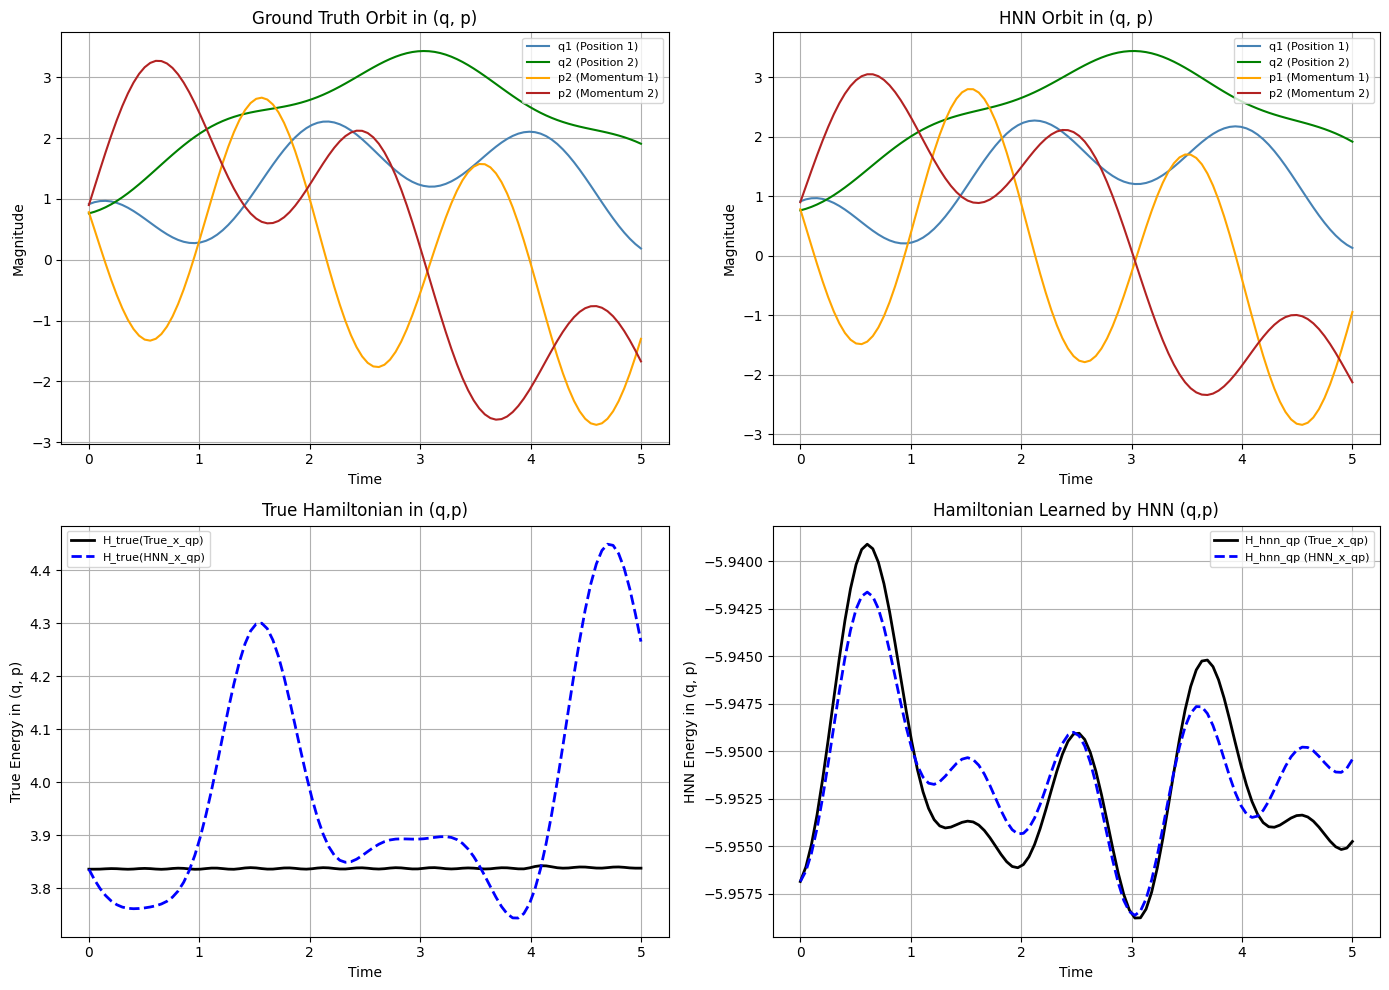

In [11]:
plot_fig1(true_x_qp, hnn_x_qp, t_eval, Htrue_true_x_qp, Htrue_hnn_x_qp, Hmodel_true_x_qp, Hmodel_hnn_x_qp)

In [ ]:
def plot_fig2(true_x_qv, hnn_x_qv, t_eval, Htrue_true_x_qv, Htrue_hnn_x_qv):
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    tpad = 7

    # --- Top Left Plot (0, 0): Ground Truth Trajectory ---
    axes[0, 0].plot(t_eval, true_x_qv[:, 0], 'steelblue', label='q1 (Position 1)')
    axes[0, 0].plot(t_eval, true_x_qv[:, 1], 'g', label='q2 (Position 2)')
    axes[0, 0].plot(t_eval, true_x_qv[:, 2], 'orange', label='v1 (Velocity 1)')
    axes[0, 0].plot(t_eval, true_x_qv[:, 3], 'firebrick', label='v2 (Velocity 2)')
    axes[0, 0].set_ylabel('Magnitude')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_title('Ground Truth Orbit in (q,v)')
    axes[0, 0].legend(loc='upper right', fontsize=8)
    axes[0, 0].grid(True)

    # --- Top Right Plot (0, 1): Model Prediction Trajectory ---
    axes[0, 1].plot(t_eval, hnn_x_qv[:, 0], 'steelblue', label='q1 (Position 1)')
    axes[0, 1].plot(t_eval, hnn_x_qv[:, 1], 'g', label='q2 (Position 2)')
    axes[0, 1].plot(t_eval, hnn_x_qv[:, 2], 'orange', label='v1 (Velocity 1)')
    axes[0, 1].plot(t_eval, hnn_x_qv[:, 3], 'firebrick', label='v2 (Velocity 2)')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_title('HNN Orbit in (q,v) from (q,p)')
    axes[0, 1].legend(loc='upper right', fontsize=8)
    axes[0, 1].grid(True)

    # --- Bottom Left Plot (1, 0): True Hamiltonian Perspective ---
    axes[1, 0].plot(t_eval, Htrue_true_x_qv, 'k-', label='H_true(True_x_qv)', linewidth=2)
    axes[1, 0].plot(t_eval, Htrue_hnn_x_qv, 'b--', label='H_true(HNN_x_qv)', linewidth=2)
    axes[1, 0].set_title("True Hamiltonian in (q,v) from (q,p)", pad=tpad)
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('True Energy in (q,v) from (q,p)')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(True)

    plt.tight_layout()
    plt.savefig("./eval_figures_per_model/hnn_ms_qp_eval_figure_2_by_danieljh.png", dpi=150) # PNG saved
    plt.show()

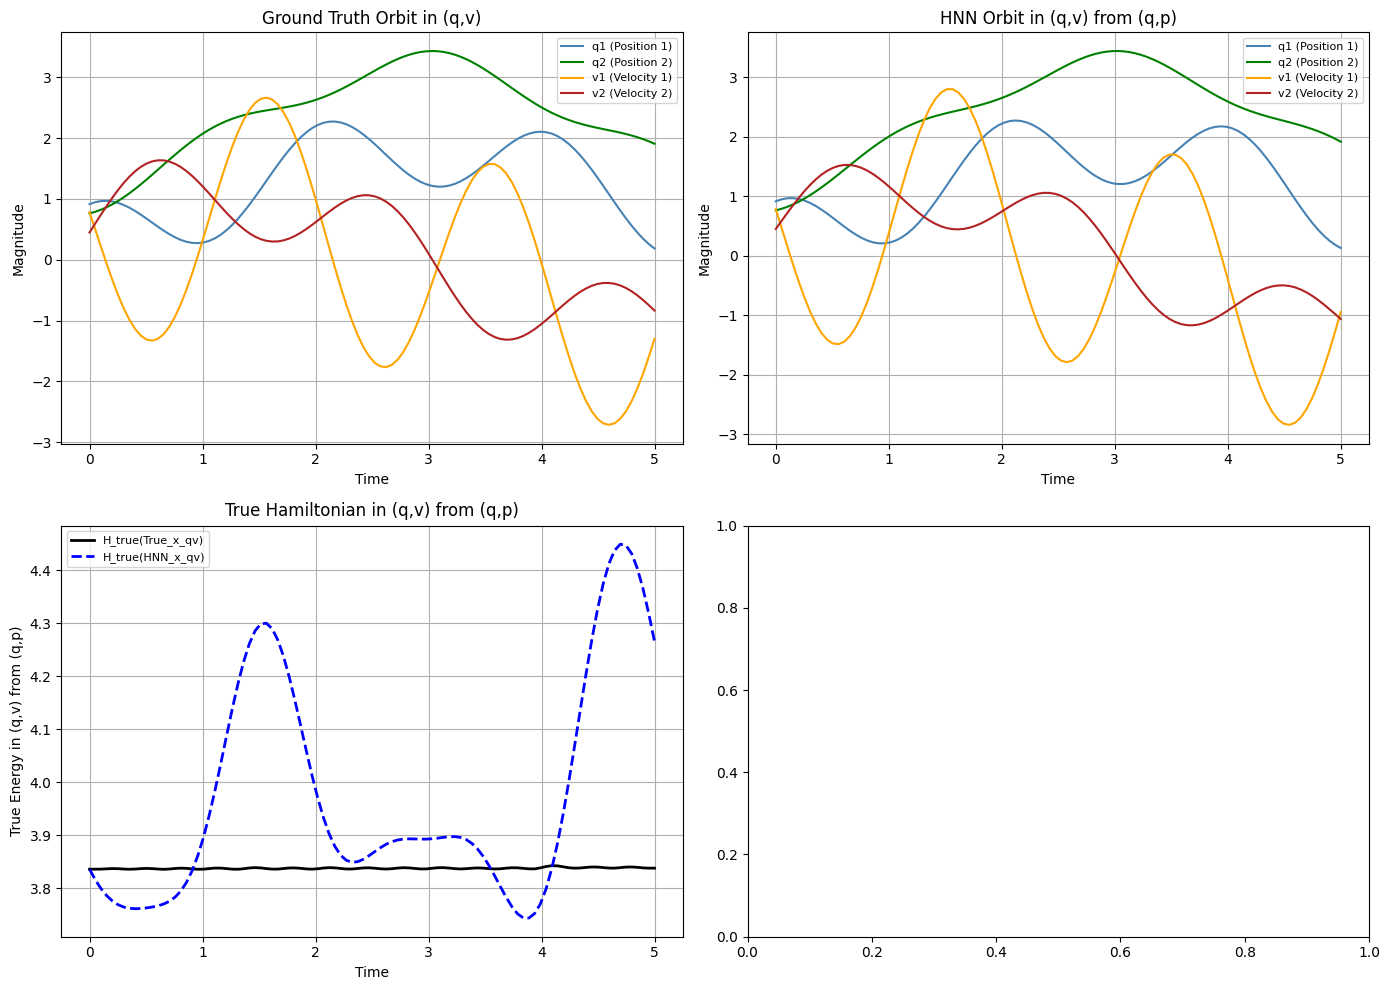

In [13]:
plot_fig2(true_x_qv, hnn_x_qv, t_eval, Htrue_true_x_qv, Htrue_hnn_x_qv)

In [ ]:
''' In order to compare performances across models, exports orbit, etc. to file '''
def save_data(data, model="TRUE_ms", item='orbit', t_end=tend, dir = './comparison'): 
    # model = "TRUE", "HNN" "LNN", "SYM", "SKEW", "NODE"
    file_path = dir + f'/{model}_{item}_tend_{t_end}.npy'
    np.save(file_path, data)

    print(f"Data have successfully saved to {file_path}.")

In [ ]:
save_data(true_x_qp, model="TRUE_ms_qp", item="orbit")
save_data(true_x_qv, model="TRUE_ms_qv", item="orbit")
save_data(hnn_x_qp, model="HNN_ms_qp", item="orbit")
save_data(hnn_x_qv, model="HNN_ms_qv", item="orbit")
save_data(Htrue_true_x_qp, model="HNN_ms_qp", item="Htrue_true_x_qp")
save_data(Htrue_hnn_x_qp, model="HNN_ms_qp", item='Htrue_hnn_x_qp')
save_data(Hmodel_true_x_qp, model="HNN_ms_qp", item='Hmodel_true_x_qp')
save_data(Hmodel_hnn_x_qp, model="HNN_ms_qp", item='Hmodel_hnn_x_qp')

데이터가 ./comparison/TRUE_ms_qp_orbit_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/TRUE_ms_qv_orbit_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_ms_qp_orbit_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_ms_qv_orbit_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_ms_qp_Htrue_true_x_qp_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_ms_qp_Htrue_hnn_x_qp_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_ms_qp_Hmodel_true_x_qp_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_ms_qp_Hmodel_hnn_x_qp_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
